## Import Libraries

In [4]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings("ignore")

In [5]:
def reduce_mem_usage(df, verbose=False):
    '''
    reduce memory usage by downcasting data types
    from https://www.kaggle.com/harupy/m5-baseline
    '''
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    int_columns = df.select_dtypes(include=["int"]).columns
    float_columns = df.select_dtypes(include=["float"]).columns

    for col in int_columns:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast="float")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df


Reading csv from 

Mem. usage decreased to  3.24 Mb (48.4% reduction)


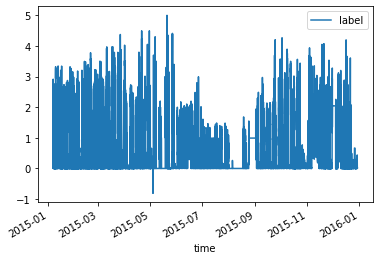

In [6]:
data = pd.read_excel('https://github.com/cruveilc/Occupancy-Forecasting/blob/main/output.xlsx?raw=true',
sheet_name=0,
header=0,
index_col=[0],
keep_default_na=True
).pipe(reduce_mem_usage, verbose=True)

#data = data[data.index.dayofweek < 5]
#data = data.between_time('06:00','23:00')

data = data[['label']]
split_date = '05-May-2015'
data.plot()

time = data.index

Creating Multistep parameters

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('label%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('label%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('label%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.index = time
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
     
    return agg

Scaling

In [8]:
data2=data[['label']]

#print(data.iloc[:,0])
#labelEncoder = LabelEncoder()
#data.iloc[:,0] = labelEncoder.fit_transform(data.iloc[:,0])
values = data2.values
print(values.shape)
values = values.astype('float32')

(102930, 1)


Here is the cell that enables to change how much past data you use and what is the fprecasting horizon. These parameters are important since they are used to construct the neural networks layers.

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
n_in =12*24*2
n_out=12*24
#scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(values,n_in,n_out)



reframed

,label1(t-576),label1(t-575),label1(t-574),label1(t-573),label1(t-572),label1(t-571),label1(t-570),label1(t-569),label1(t-568),label1(t-567),label1(t-566),label1(t-565),label1(t-564),label1(t-563),label1(t-562),label1(t-561),label1(t-560),label1(t-559),label1(t-558),label1(t-557),label1(t-556),label1(t-555),label1(t-554),label1(t-553),label1(t-552),label1(t-551),label1(t-550),label1(t-549),label1(t-548),label1(t-547),label1(t-546),label1(t-545),label1(t-544),label1(t-543),label1(t-542),label1(t-541),label1(t-540),label1(t-539),label1(t-538),label1(t-537),...,label1(t+248),label1(t+249),label1(t+250),label1(t+251),label1(t+252),label1(t+253),label1(t+254),label1(t+255),label1(t+256),label1(t+257),label1(t+258),label1(t+259),label1(t+260),label1(t+261),label1(t+262),label1(t+263),label1(t+264),label1(t+265),label1(t+266),label1(t+267),label1(t+268),label1(t+269),label1(t+270),label1(t+271),label1(t+272),label1(t+273),label1(t+274),label1(t+275),label1(t+276),label1(t+277),label1(t+278),label1(t+279),label1(t+280),label1(t+281),label1(t+282),label1(t+283),label1(t+284),label1(t+285),label1(t+286),label1(t+287)
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-08 15:00:00,1.128000,0.622000,0.634000,0.285733,0.094,0.062,0.006,0.086,0.090,0.000000,0.030000,0.232000,0.194000,1.084933,1.975573,2.213253,2.532,2.390000,2.442000,2.300000,1.804000,1.605947,1.633173,1.794000,1.625440,1.597173,1.647173,2.322000,2.316907,2.308000,1.548853,1.641440,1.625173,1.605947,1.536853,2.340907,2.402907,1.536853,2.432907,2.566907,...,2.252907,1.813440,2.284907,1.844000,1.631813,2.618907,2.432907,2.298000,2.340907,2.436907,2.336907,2.556840,2.482907,2.049207,1.358853,1.536853,1.635440,2.346907,1.81344,1.794000,1.652000,1.892000,1.625440,1.755173,1.952000,1.793440,1.944000,2.316000,1.605173,2.432907,1.408853,2.604907,1.182867,2.034113,1.853207,1.929107,1.972107,1.972107,1.350087,1.837207
2015-01-08 15:05:00,0.622000,0.634000,0.285733,0.094000,0.062,0.006,0.086,0.090,0.000,0.030000,0.232000,0.194000,1.084933,1.975573,2.213253,2.532000,2.390,2.442000,2.300000,1.804000,1.605947,1.633173,1.794000,1.625440,1.597173,1.647173,2.322000,2.316907,2.308000,1.548853,1.641440,1.625173,1.605947,1.536853,2.340907,2.402907,1.536853,2.432907,2.566907,2.716000,...,1.813440,2.284907,1.844000,1.631813,2.618907,2.432907,2.298000,2.340907,2.436907,2.336907,2.556840,2.482907,2.049207,1.358853,1.536853,1.635440,2.346907,1.813440,1.79400,1.652000,1.892000,1.625440,1.755173,1.952000,1.793440,1.944000,2.316000,1.605173,2.432907,1.408853,2.604907,1.182867,2.034113,1.853207,1.929107,1.972107,1.972107,1.350087,1.837207,1.267993
2015-01-08 15:10:00,0.634000,0.285733,0.094000,0.062000,0.006,0.086,0.090,0.000,0.030,0.232000,0.194000,1.084933,1.975573,2.213253,2.532000,2.390000,2.442,2.300000,1.804000,1.605947,1.633173,1.794000,1.625440,1.597173,1.647173,2.322000,2.316907,2.308000,1.548853,1.641440,1.625173,1.605947,1.536853,2.340907,2.402907,1.536853,2.432907,2.566907,2.716000,2.756000,...,2.284907,1.844000,1.631813,2.618907,2.432907,2.298000,2.340907,2.436907,2.336907,2.556840,2.482907,2.049207,1.358853,1.536853,1.635440,2.346907,1.813440,1.794000,1.65200,1.892000,1.625440,1.755173,1.952000,1.793440,1.944000,2.316000,1.605173,2.432907,1.408853,2.604907,1.182867,2.034113,1.853207,1.929107,1.972107,1.972107,1.350087,1.837207,1.267993,1.971293
2015-01-08 15:15:00,0.285733,0.094000,0.062000,0.006000,0.086,0.090,0.000,0.030,0.232,0.194000,1.084933,1.975573,2.213253,2.532000,2.390000,2.442000,2.300,1.804000,1.605947,1.633173,1.794000,1.625440,1.597173,1.647173,2.322000,2.316907,2.308000,1.548853,1.641440,1.625173,1.605947,1.536853,2.340907,2.402907,1.536853,2.432907,2.566907,2.716000,2.756000,2.668000,...,1.844000,1.631813,2.618907,2.432907,2.298000,2.340907,2.436907,2.336907,2.556840,2.482907,2.049207,1.358853,1.536853,1.635440,2.346907,1.813440,1.794000,1.652000,1.89200,1.625440,1.755173,1.952000,1.793440,1.944000,2.316000,1.605173,2.432907,1.4088

In [10]:
#reframed.insert(0,'hour',reframed.index.hour)
#reframed.insert(0,'dayofweek',reframed.index.dayofweek)
#reframed.insert(0,'dayofmonth',reframed.index.day)
#reframed.insert(0,'year',reframed.index.year)

In [11]:
reframed

,label1(t-576),label1(t-575),label1(t-574),label1(t-573),label1(t-572),label1(t-571),label1(t-570),label1(t-569),label1(t-568),label1(t-567),label1(t-566),label1(t-565),label1(t-564),label1(t-563),label1(t-562),label1(t-561),label1(t-560),label1(t-559),label1(t-558),label1(t-557),label1(t-556),label1(t-555),label1(t-554),label1(t-553),label1(t-552),label1(t-551),label1(t-550),label1(t-549),label1(t-548),label1(t-547),label1(t-546),label1(t-545),label1(t-544),label1(t-543),label1(t-542),label1(t-541),label1(t-540),label1(t-539),label1(t-538),label1(t-537),...,label1(t+248),label1(t+249),label1(t+250),label1(t+251),label1(t+252),label1(t+253),label1(t+254),label1(t+255),label1(t+256),label1(t+257),label1(t+258),label1(t+259),label1(t+260),label1(t+261),label1(t+262),label1(t+263),label1(t+264),label1(t+265),label1(t+266),label1(t+267),label1(t+268),label1(t+269),label1(t+270),label1(t+271),label1(t+272),label1(t+273),label1(t+274),label1(t+275),label1(t+276),label1(t+277),label1(t+278),label1(t+279),label1(t+280),label1(t+281),label1(t+282),label1(t+283),label1(t+284),label1(t+285),label1(t+286),label1(t+287)
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-08 15:00:00,1.128000,0.622000,0.634000,0.285733,0.094,0.062,0.006,0.086,0.090,0.000000,0.030000,0.232000,0.194000,1.084933,1.975573,2.213253,2.532,2.390000,2.442000,2.300000,1.804000,1.605947,1.633173,1.794000,1.625440,1.597173,1.647173,2.322000,2.316907,2.308000,1.548853,1.641440,1.625173,1.605947,1.536853,2.340907,2.402907,1.536853,2.432907,2.566907,...,2.252907,1.813440,2.284907,1.844000,1.631813,2.618907,2.432907,2.298000,2.340907,2.436907,2.336907,2.556840,2.482907,2.049207,1.358853,1.536853,1.635440,2.346907,1.81344,1.794000,1.652000,1.892000,1.625440,1.755173,1.952000,1.793440,1.944000,2.316000,1.605173,2.432907,1.408853,2.604907,1.182867,2.034113,1.853207,1.929107,1.972107,1.972107,1.350087,1.837207
2015-01-08 15:05:00,0.622000,0.634000,0.285733,0.094000,0.062,0.006,0.086,0.090,0.000,0.030000,0.232000,0.194000,1.084933,1.975573,2.213253,2.532000,2.390,2.442000,2.300000,1.804000,1.605947,1.633173,1.794000,1.625440,1.597173,1.647173,2.322000,2.316907,2.308000,1.548853,1.641440,1.625173,1.605947,1.536853,2.340907,2.402907,1.536853,2.432907,2.566907,2.716000,...,1.813440,2.284907,1.844000,1.631813,2.618907,2.432907,2.298000,2.340907,2.436907,2.336907,2.556840,2.482907,2.049207,1.358853,1.536853,1.635440,2.346907,1.813440,1.79400,1.652000,1.892000,1.625440,1.755173,1.952000,1.793440,1.944000,2.316000,1.605173,2.432907,1.408853,2.604907,1.182867,2.034113,1.853207,1.929107,1.972107,1.972107,1.350087,1.837207,1.267993
2015-01-08 15:10:00,0.634000,0.285733,0.094000,0.062000,0.006,0.086,0.090,0.000,0.030,0.232000,0.194000,1.084933,1.975573,2.213253,2.532000,2.390000,2.442,2.300000,1.804000,1.605947,1.633173,1.794000,1.625440,1.597173,1.647173,2.322000,2.316907,2.308000,1.548853,1.641440,1.625173,1.605947,1.536853,2.340907,2.402907,1.536853,2.432907,2.566907,2.716000,2.756000,...,2.284907,1.844000,1.631813,2.618907,2.432907,2.298000,2.340907,2.436907,2.336907,2.556840,2.482907,2.049207,1.358853,1.536853,1.635440,2.346907,1.813440,1.794000,1.65200,1.892000,1.625440,1.755173,1.952000,1.793440,1.944000,2.316000,1.605173,2.432907,1.408853,2.604907,1.182867,2.034113,1.853207,1.929107,1.972107,1.972107,1.350087,1.837207,1.267993,1.971293
2015-01-08 15:15:00,0.285733,0.094000,0.062000,0.006000,0.086,0.090,0.000,0.030,0.232,0.194000,1.084933,1.975573,2.213253,2.532000,2.390000,2.442000,2.300,1.804000,1.605947,1.633173,1.794000,1.625440,1.597173,1.647173,2.322000,2.316907,2.308000,1.548853,1.641440,1.625173,1.605947,1.536853,2.340907,2.402907,1.536853,2.432907,2.566907,2.716000,2.756000,2.668000,...,1.844000,1.631813,2.618907,2.432907,2.298000,2.340907,2.436907,2.336907,2.556840,2.482907,2.049207,1.358853,1.536853,1.635440,2.346907,1.813440,1.794000,1.652000,1.89200,1.625440,1.755173,1.952000,1.793440,1.944000,2.316000,1.605173,2.432907,1.4088

In [12]:
values1 = reframed.values
n_train = 80000
n_date=0
train = values1[:n_train]
test = values1[n_train:]
trainX,trainY = train[:,:-n_out],train[:,n_date+n_in:]
testX,testY = test[:,:-n_out],test[:,n_date+n_in:]

print(trainX.shape,trainY.shape,testX.shape,testY.shape)

(80000, 576) (80000, 288) (22067, 576) (22067, 288)


In [13]:
#trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
#testX = testX.reshape(testX.shape[0],1,testX.shape[1])

Testing MLP Model

In [14]:
epochs = 10
batch = 10
lr = 0.001

adam = optimizers.Adam(lr)

model_mlp = Sequential()
model_mlp.add(Dense(n_in+n_date, activation='relu', input_dim=n_in+n_date))
model_mlp.add(Dense(n_in+n_date))


model_mlp.add(Dense(n_out))
model_mlp.compile(loss='mse', optimizer=adam)

In [15]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 576)               332352    
_________________________________________________________________
dense_1 (Dense)              (None, 576)               332352    
_________________________________________________________________
dense_2 (Dense)              (None, 288)               166176    
Total params: 830,880
Trainable params: 830,880
Non-trainable params: 0
_________________________________________________________________


In [16]:
mlp_history = model_mlp.fit(trainX, trainY,epochs=epochs, verbose=2)

Epoch 1/10
2500/2500 - 19s - loss: 0.4436
Epoch 2/10
2500/2500 - 19s - loss: 0.3901
Epoch 3/10
2500/2500 - 19s - loss: 0.3639
Epoch 4/10
2500/2500 - 19s - loss: 0.3456
Epoch 5/10
2500/2500 - 19s - loss: 0.3325
Epoch 6/10
2500/2500 - 19s - loss: 0.3224
Epoch 7/10
2500/2500 - 19s - loss: 0.3153
Epoch 8/10
2500/2500 - 19s - loss: 0.3082
Epoch 9/10
2500/2500 - 19s - loss: 0.3031
Epoch 10/10
2500/2500 - 19s - loss: 0.2988


In [17]:
yhat = model_mlp.predict(testX, verbose=0)

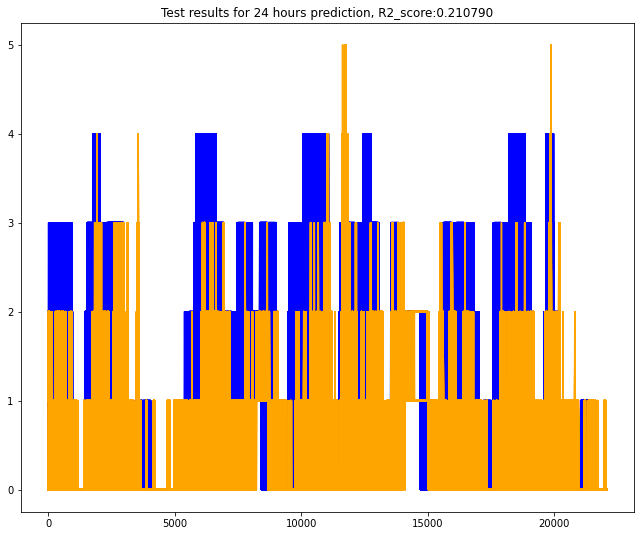

In [18]:
from sklearn.metrics import r2_score
yhat[yhat <= 0.1] = 0
#ypred=ypred.reshape((testY.shape[0]))
plt.figure(figsize=(11,9))
plt.plot(testY.round(0),label='Orginal',color = 'blue')
plt.plot(yhat.round(0),label='Predicted',color = 'Orange')
plt.title('Test results for 24 hours prediction, R2_score:%f'%r2_score(testY,yhat))
plt.show()
#plt.legend(loc='best')


In [19]:
X_train_series = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
X_valid_series = testX.reshape((testX.shape[0], testX.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (80000, 576, 1)
Validation set shape (22067, 576, 1)


Testing CNN-LSTM model

In [20]:
subsequences = 2
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (80000, 2, 288, 1)
Validation set shape (22067, 2, 288, 1)


In [21]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(12*24))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [22]:


cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, trainY, validation_data=(X_valid_series_sub, testY), epochs=3, verbose=2)



Epoch 1/3
2500/2500 - 112s - loss: 0.4195 - val_loss: 0.5755
Epoch 2/3
2500/2500 - 110s - loss: 0.3425 - val_loss: 0.6432
Epoch 3/3
2500/2500 - 110s - loss: 0.3024 - val_loss: 0.6711


0.12235636939912824


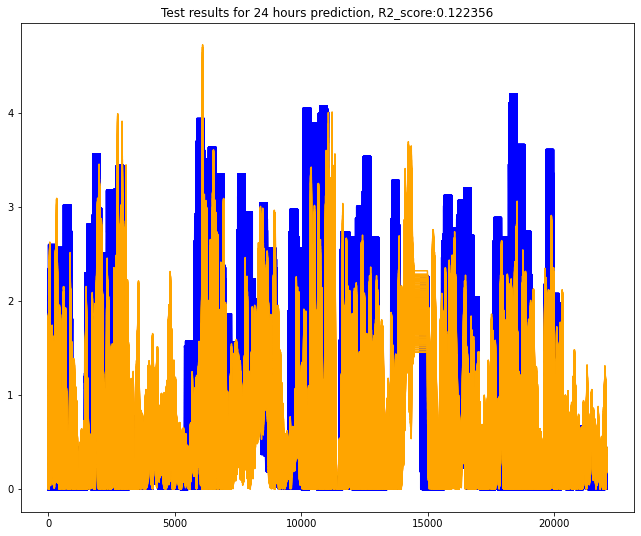

In [23]:
from sklearn.metrics import r2_score
ypred = model_cnn_lstm.predict(X_valid_series_sub)

for k in range(0,len(ypred)):
  for j in range(0,len(ypred[k])):
    if ypred[k][j]<0:
      ypred[k][j]=0

#ypred=ypred.reshape((testY.shape[0]))
plt.figure(figsize=(11,9))
plt.plot(testY,label='Orginal',color='blue')
plt.plot(ypred,label='Predicted',color='orange')
#plt.legend(loc='best')
plt.title('Test results for 24 hours prediction, R2_score:%f'%r2_score(testY,ypred))
print(r2_score(testY,ypred))